In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from time import time

# sets the default float-type
tf.keras.backend.set_floatx('float32')

class AxialBar1D:

  def __init__(self, xmin, xmax, q, N=1000, num_hidden_layers=1, num_neurons_per_layer=20, activation='tanh', actual_solution=None, epochs=5000):

    self.N = N
    self.epochs = epochs
    self.xmin = xmin
    self.xmax = xmax
    self.model = self.initialize_NN(num_hidden_layers, num_neurons_per_layer, activation)
    self.X = self.get_data()
    self.q = q
    self.learning_rate = tf.keras.optimizers.schedules.PiecewiseConstantDecay([3000,10000],[1e-2,1e-4,5e-5])
    # self.learning_rate = 1e-3
    self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
    self.actual_solution = actual_solution
  
  def get_data(self):

    # X = tf.random.uniform((self.N, 1), minval=self.xmin, maxval=self.xmax)
    # X = tf.expand_dims(tf.sort(tf.squeeze(X)), axis=-1)
    X = tf.linspace(start=self.xmin, stop=self.xmax, num=self.N)
    X = tf.expand_dims(X, axis=-1)
    X = tf.cast(X, dtype=tf.float32)
    return X
  
  def initialize_NN(self, num_hidden_layers, num_neurons_per_layer, activation):
    model = tf.keras.Sequential()
    # Add input layer
    model.add(tf.keras.Input(1))
    # Add the hidden layers
    for i in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer, activation, kernel_initializer='glorot_normal'))
    # Add output layer
    model.add(tf.keras.layers.Dense(1))
    return model
  
  def psi(self, dudx):
    return (1+dudx)**1.5 - 1.5*dudx - 1
  
  def trapz(self, y):

    h = (self.xmax - self.xmin)/self.N
    integrand = y
    integrand1 = integrand[1:]
    integrand0 = integrand[:-1]
    integral = (h/2)*tf.reduce_sum(integrand1 + integrand0)
    return integral

  def get_loss(self):

    with tf.GradientTape(persistent=True) as tape:
      x = self.X
      tape.watch(x)

      # Find u (output of the model)
      u = (x+1)*self.model(x)
      dudx = tape.gradient(u, x)
      psi_of_x = self.psi(dudx)
      # Perform trapeoidal integration
      integral = self.trapz(psi_of_x) - self.trapz(u*self.q(x))
      print(integral)
    
    loss = integral
    return loss
  
  def get_gradients(self):
    with tf.GradientTape(persistent=True) as tape:
      # This tape is for derivatives with
      # respect to trainable variables
      tape.watch(self.model.trainable_variables)
      loss = self.get_loss()

    g = tape.gradient(loss, self.model.trainable_variables)
    del tape
    return loss, g
  
  @tf.function
  def train_step(self):
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = self.get_gradients()
    # Perform gradient descent step
    self.optimizer.apply_gradients(zip(grad_theta, self.model.trainable_variables))
    return loss
  
  def train(self):
    epochs = self.epochs
    hist = []

    # Start timer
    t0 = time()

    for i in range(epochs+1):
        
        loss = self.train_step()
        # Append current loss to hist
        hist.append(loss.numpy())
        # Output current loss after 50 iterates
        if i%50 == 0:
            print(f'It {i}: loss = {loss.numpy()}')
    # Print computation time
    print('\nComputation time: {} seconds'.format(time()-t0))

    # Get the mean_absolute error
    predictions = self.predict(self.X)
    if self.actual_solution != None:
      mae = tf.reduce_mean(tf.abs(predictions-self.actual_solution(self.X)))
      mse = tf.reduce_mean(tf.square(predictions-self.actual_solution(self.X)))
      mape = tf.reduce_mean(tf.abs(predictions-self.actual_solution(self.X))/self.actual_solution(self.X))
    else:
      mae = None
      mse = None
      mape = None
    return {'training_history': hist, 'training_time':time()-t0, 'mae': mae, 'mse':mse, 'mape':mape}
  
  def plot_results(self):
    with tf.GradientTape(persistent=True) as tape:
      tape.watch(self.X)
      predicted_solution = (self.X+1)*self.model(self.X)
      predicted_slope = tape.gradient(predicted_solution, self.X)
      plt.figure(figsize=(10, 10))
      plt.plot(self.X, predicted_solution, label='predicted', color='cyan', linewidth=7 )
      if self.actual_solution != None:
        actual_solution = self.actual_solution(self.X)
        actual_slope = tape.gradient(actual_solution, self.X)
        plt.plot(self.X, actual_solution, label='actual', linestyle='dashed', color='red', linewidth=7)
      plt.xlabel("X")
      plt.ylabel("u(X)")
      plt.title("Axial Loading Prediction")
      plt.legend()
      # Plot the slope
      plt.figure(figsize=(10, 10))
      if self.actual_solution != None:
        plt.plot(self.X, actual_slope, label='actual', color='red', linewidth=7)
      plt.plot(self.X, predicted_slope, linewidth=7, label='predicted', color='lightgreen', linestyle='dashed')
      plt.xlabel("X")
      plt.ylabel("du(X)/dx")
      plt.title("Axial Loading Prediction Slope")
      plt.legend()
      plt.show()
    
  def predict(self, X):
    return (X+1)*self.model.predict(X)


Tensor("sub_2:0", shape=(), dtype=float32)
Tensor("sub_2:0", shape=(), dtype=float32)
It 0: loss = -0.028837576508522034
It 50: loss = -0.17576749622821808
It 100: loss = -0.19327150285243988
It 150: loss = -0.1936875879764557
It 200: loss = -0.19387152791023254
It 250: loss = -0.19401152431964874
It 300: loss = -0.19411833584308624
It 350: loss = -0.19419828057289124
It 400: loss = -0.19425761699676514
It 450: loss = -0.19430182874202728
It 500: loss = -0.19433511793613434
It 550: loss = -0.19436073303222656
It 600: loss = -0.194380983710289
It 650: loss = -0.19439753890037537
It 700: loss = -0.1944115161895752
It 750: loss = -0.19442355632781982
It 800: loss = -0.19443407654762268
It 850: loss = -0.19444353878498077
It 900: loss = -0.19445200264453888
It 950: loss = -0.19445963203907013
It 1000: loss = -0.19446660578250885
It 1050: loss = -0.19447295367717743
It 1100: loss = -0.19447869062423706
It 1150: loss = -0.1944839209318161
It 1200: loss = -0.19448859989643097
It 1250: loss = 

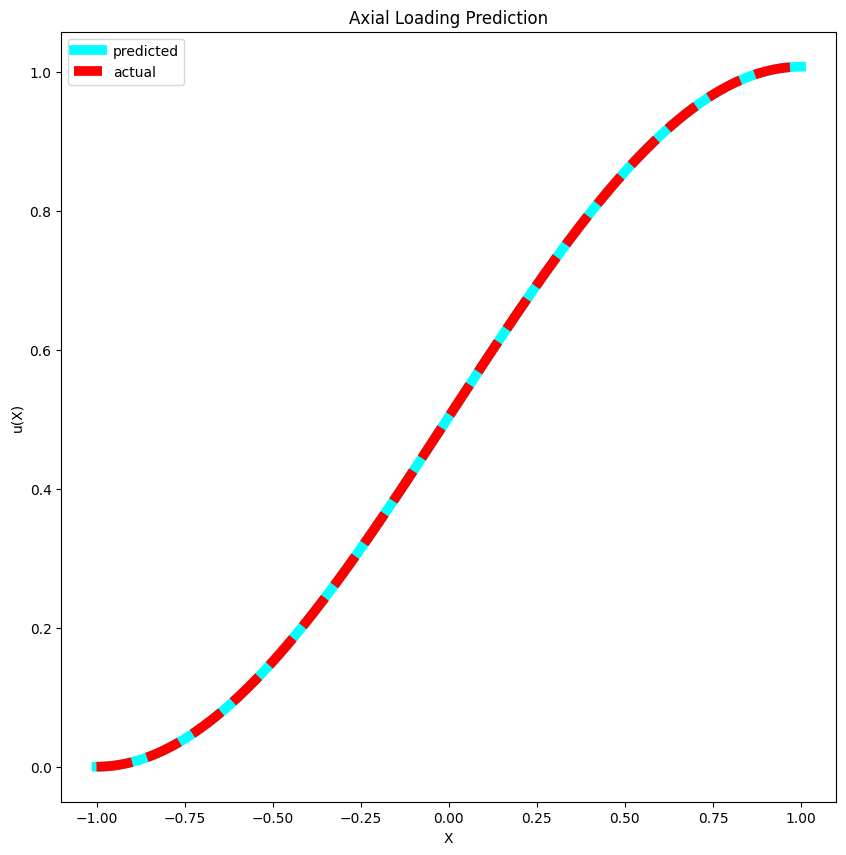

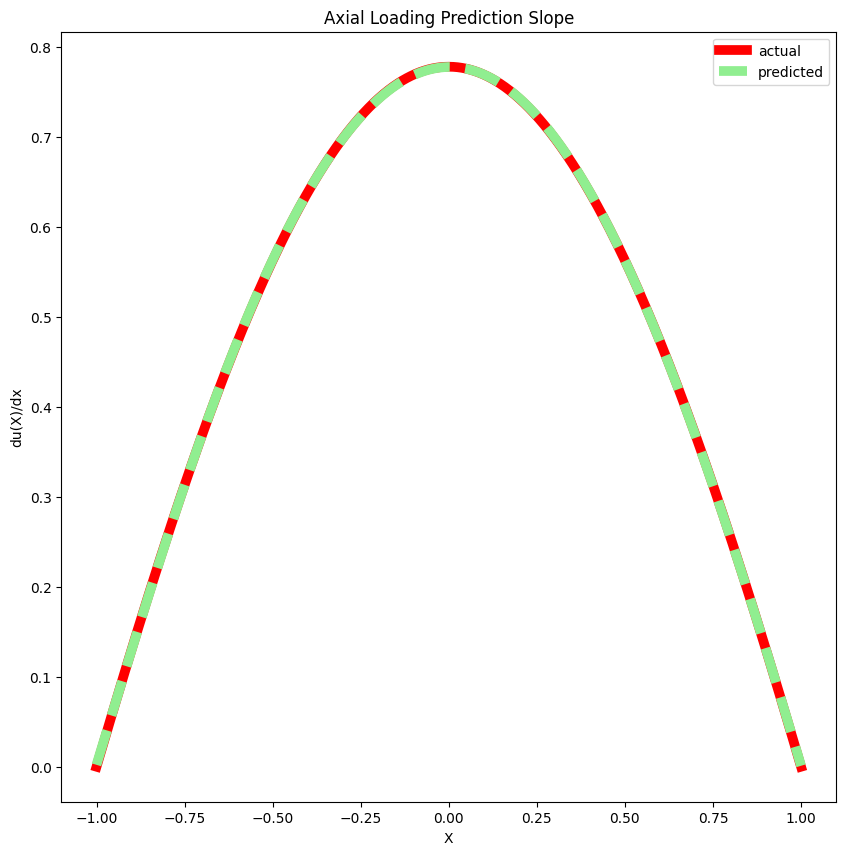

Training time: 29.03537392616272
Mean Absolute Error: 4.8197216528933495e-05
Mean Squared Error: 2.913831842477066e-09
Mean Absolute Percentage Error: nan


In [ ]:
xmax = 1
xmin = -1

def q(X):
  return X

def actual_solution(X):
  return (68 + 105*X -40*X**3 + 3*X**5)/135

mymodel = AxialBar1D(xmax=xmax,
                     xmin = xmin,
                   q=q,
                   N=1000,
                   num_hidden_layers=1,
                   num_neurons_per_layer=10,
                   actual_solution=actual_solution,
                   epochs = 30000)

history = mymodel.train()
mymodel.plot_results()
# Get the training time:
training_time = history['training_time']
mae = history['mae']
mse = history['mse']
mape = history['mape']
print(f'Training time: {training_time}')
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Percentage Error: {mape}')

In [ ]:
len(history['training_history'])

30001

Text(0.5, 1.0, 'Loss Curve')

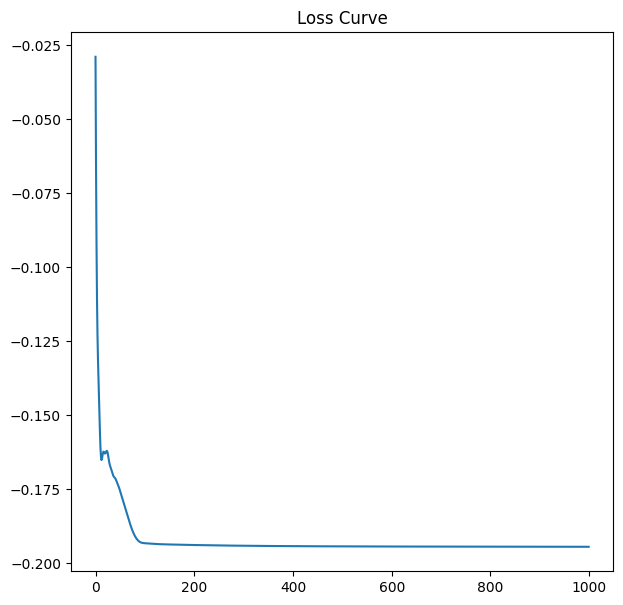

In [ ]:
plt.figure(figsize=(7, 7))
plt.plot(range(1000), history['training_history'][:1000])
plt.title('Loss Curve')